# orbitalCADENCE: Orbital Content-Aware Data comprEssioN for multispeCtral Environments.

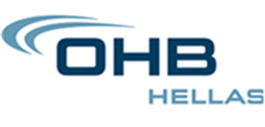

## 1. Executive summary

### The Problem
The rapid advancements in satellite technology have led to a massive surge in the volume of high-resolution data being captured and transmitted from space. With the increasing capacity for data collection, one significant challenge that has emerged is the real-time downlink transmission of this voluminous data to Earth. Traditional methods of transmission can often result in a data bottleneck, causing substantial delays and hindering the timely analysis of critical data, such as meteorological forecasts or disaster management efforts. Moreover, the sheer volume of the data often exceeds the available bandwidth for transmission, necessitating the need for efficient data compression methods.

### Our Solution

In response to this challenge, our approach leverages the capabilities of a Vector Quantized Variational AutoEncoder (VQ-VAE) to compress images for transmission. The VQ-VAE operates by transforming the high-dimensional input data into a lower-dimensional latent space, thereby achieving significant compression. To further refine this process, we incorporate an unsupervised classifier to identify areas of interest within the images. This selective approach enables us to prioritize and efficiently transmit pertinent data, thereby optimizing the use of bandwidth and allowing for real-time downlink transmission of satellite data. The compressed images are then decoded on the ground, providing us with the critical information we need when we need it.

**This is especially pertinent for us, as, while we are implementing this challenge, our country (Greece) is ravaged by wildfires, floods and multi-casualty shipwrecks, that faster, real-time satellite transmissions could mitigate or even prevent completely.**

### Indicative Pipeline

-----------on-board-----------
1. Image gets captured.
2. Image gets encoded with the Low Compression Encoder ($LC_E$).
3. Image encoding gets classified.
4.    
    1. If encoding gets classified as useful, it is sent to earth as is.
    2. If encoding gets classified as not useful, the original image gets encoded with High Compression Encoder ($HC_E$), then gets sent to earth.
    
-----------on-ground-----------

1. If the image was classified as useful, it is decoded with the Low Compression Decoder ($LC_D$).
2. If the image was classified as not useful, it is decoded with the High Compression Decoder ($HC_D$).
---

## 2. Imports and code dependencies

In [ ]:
import os
import numpy as np

#!pip uninstall tensorflow -y
!pip install tensorflow==1.15
#!pip install tensorflow-gpu==1.15
import tensorflow as tf
print(tf.__version__)

!pip install rasterio
import rasterio

ROOT = './'

BATCH_SIZE = 32

## 3. Preprocessing

### 3.1. Helper Functions

In [ ]:
# Image Compression Plots

def show(img):
    npimg = img #npimg = img.numpy()
    # import pdb;pdb.set_trace()
    fig = plt.imshow(np.transpose(npimg, (1,2,0))[...,[2,1,0]], interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

def n_mean_squared_error(img1, img2, data_variance):
    return F.mse_loss(img1, img2)/data_variance

def compare_image(original, reconstruction, data_variance):
    _, axes = plt.subplots(1, 2)
    axes[0].imshow(np.transpose(original, (1,2,0))[...,[2,1,0]], interpolation='nearest')
    axes[0].axis("off")
    axes[1].imshow(np.transpose(reconstruction, (1,2,0))[...,[2,1,0]], interpolation='nearest')
    axes[1].axis("off")
    plt.show()
    mse_pt = n_mean_squared_error(original, reconstruction, data_variance)
    print(f"NMSE : {mse_pt}")

def compare_size(img1, embedding, img2):
    img1 = img1.cpu().detach().numpy()
    embedding = embedding.cpu().detach().numpy()
    img2 = img2.cpu().detach().numpy()
    print(f"Size of encoder input = {img1.size * img1.itemsize} bytes")
    print(f"Size of embedding space = {embedding.size * embedding.itemsize} bytes")
    print(f"Size of decoder output = {img2.size * img2.itemsize} bytes")
    print(f"Compression ratio input/embedding = {(img1.size * img1.itemsize) / (embedding.size * embedding.itemsize) }")

def single_classification_prep(encoding_array):
  if encoding_array.shape[0] == 32768:
      ind_dist = np.reshape(encoding_array, (1, 64, 64))
  elif encoding_array.shape[0] == 4096:
      ind_dist = np.reshape(encoding_array, (1, 64, 64))
  else:
      raise ValueError(f"Unexpected size {encoding_array.shape[0]}")
  rows_to_add = [ind.flatten() for ind in ind_dist]
  counts = []
  for ii in rows_to_add:
    # creating 1024 bins and counting occurences
    bins = np.linspace(0, ii.max(), 1024)
    digitized = np.digitize(ii, bins)
    binned_count = np.bincount(digitized)[1:]
    counts.append(binned_count)
  return counts

### 3.2. Data Acquisition
In this section we read the predefined labels for the zips of images and then download them from the AWS S3 bucket.

In [ ]:
# we read the predefined labels for the train/test/validation split

verbose = False # <---  set True for verbose output

"""
with open(ROOT + 'labels/' + 'train_data_labels.txt', 'r') as f:
    train_labels = f.readlines()
train_labels = [[url.strip()] for url in train_labels]
print(f'Train [{len(train_labels)*256}]')
if verbose:
    print(tabulate(sorted(train_labels)))

with open(ROOT + 'labels/' + 'validation_data_labels.txt', 'r') as f:
    val_labels = f.readlines()
val_labels = [[url.strip()] for url in val_labels]
print(f'Validation [{len(val_labels)*256}]')
if verbose:
    print(tabulate(sorted(val_labels)))
"""
with open(ROOT + 'labels/' + 'test_data_labels.txt', 'r') as f:
    test_labels = f.readlines()
test_labels = [[url.strip()] for url in test_labels]
print(f'Test [{len(test_labels)*256}]')
if verbose:
    print(tabulate(sorted(test_labels)))

In [ ]:
url = 'XXX'

def download_data(download_dir, file_name):
    """
    Download a single file from the OrbitalAI data
    """
    # Start the download
    file_name = os.path.basename(file_name)
    print("Downloading " + file_name)
    r = requests.get(url + file_name)
    if r.ok: # If the request is successful
        print("Writing  " + file_name)
        with open(download_dir + file_name, "wb") as f:
            f.write(r.content)
    else: # If the request is not successful
        print("Error while downloading " + file_name + "...")
        print("Status code : " + str(r.status_code))

def aws_download_resolve(download_dir, label_file):
    """
    creates download directory, unzips and cleans data
    """
    if not os.path.isdir(download_dir):
        os.makedirs(download_dir)
        for file_name in label_file: # for all in the predefined respective label file
            download_data(download_dir, file_name[0])
            zip_name = os.path.basename(file_name[0])
            local_path = os.path.join(download_dir, zip_name)
            # unzip the file
            with zipfile.ZipFile(local_path, 'r') as zip_ref:
                print('Extracting ', file_name[0])
                zip_ref.extractall(download_dir)
            # delete the zip file after extraction
            os.remove(local_path)
            for filename in os.listdir(download_dir + 'tiff_folder'):
              if "PHISAT2-BANDS" not in filename: # only keep the images we work on
                  file_path = os.path.join(download_dir + 'tiff_folder', filename)
                  # check if it's a file and not a directory
                  if os.path.isfile(file_path):
                      os.remove(file_path)
              else:
                shutil.move(os.path.join(download_dir + 'tiff_folder', filename), download_dir + filename)
        os.rmdir(download_dir + 'tiff_folder')
    else:
        #!rm -rf test_data/
        print(f"Error: The directory '{download_dir}' already exists.")

aws_download_resolve("test_data/", test_labels)

### 3.3. Dataloader

In [ ]:
def load_and_preprocess_image(image_path, transforms=None):
    with rasterio.open(image_path.decode('utf-8'), 'r') as src:
        image = src.read()
        image = np.transpose(image, (1,2,0))
        image = image / image.max()

    if transforms:
        image = transforms(image)

    return image

def tf_load_and_preprocess_image(image_path, transforms=None):
    image = tf.py_func(load_and_preprocess_image, [image_path, transforms], tf.float32)
    return image

# crawl path and create a dataset of file paths
file_pattern = os.path.join(ROOT, 'test_data', '*.tiff')
files_ds = tf.data.Dataset.list_files(file_pattern, shuffle=False)

# apply load and preprocess function
test_dataset_tf = files_ds.map(lambda x: tf_load_and_preprocess_image(x, data_transform))

# batching
loader_tf = test_dataset_tf.batch(BATCH_SIZE)

## 4. Model

### 4.1. Model Definition

In [ ]:
#!/usr/bin/python3
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)


class Residual(tf.keras.layers.Layer):
    def __init__(self, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()

        self._block = tf.keras.Sequential([
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(filters=num_residual_hiddens,
                                   kernel_size=3,
                                   padding='same',
                                   use_bias=False),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(filters=num_hiddens,
                                   kernel_size=1,
                                   use_bias=False)
        ])

    def call(self, x):
        return x + self._block(x)


class ResidualStack(tf.keras.layers.Layer):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()

        self._num_residual_layers = num_residual_layers
        self._layers = [Residual(num_hiddens, num_residual_hiddens)
                        for _ in range(num_residual_layers)]

    def call(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return tf.keras.activations.relu(x)


class VectorQuantizerEMA(tf.keras.layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        # Store parameters
        self._num_embeddings = num_embeddings
        self._embedding_dim = embedding_dim
        self._commitment_cost = commitment_cost
        self._decay = decay
        self._epsilon = epsilon

        # Create & build embedding layer
        embedding_matrix = tf.Variable(tf.random.normal([self._num_embeddings, self._embedding_dim]))
        self._embedding = tf.keras.layers.Embedding(input_dim=self._num_embeddings,
                                                    output_dim=self._embedding_dim,
                                                    weights=[embedding_matrix],
                                                    trainable=True)
        self._embedding.build((None,))

        # Initialize EMA variables
        self._ema_cluster_size = self.add_weight(name='ema_cluster_size',
                                                 shape=(self._num_embeddings,),
                                                 initializer='zeros',
                                                 trainable=True)
        self._ema_w = self.add_weight(name='ema_w',
                                      shape=(self._num_embeddings, self._embedding_dim),
                                      initializer='random_normal',
                                      trainable=True)

    def call(self, x, training=None):
        # Flatten inputs
        flat_input = tf.reshape(x, [-1, self._embedding_dim])

        # Calculate distances
        # We multiply everything with -1 because, while argmin is not supported by OpenVINO 2020.3,
        #   we can simulate it because argmin(x) == argmin(-x)
        distances = -1 * (tf.reduce_sum(flat_input**2, axis=1, keepdims=True)
                   + tf.reduce_sum(self._embedding.get_weights()[0]**2, axis=1)
                    - 2 * tf.matmul(flat_input, self._embedding.get_weights()[0], transpose_b=True))

        # Calculate encoding indices
        encoding_indices = tf.argmax(distances, axis=1)

        # Initialize encodings & updates
        encodings = tf.zeros((tf.shape(encoding_indices)[0], self._num_embeddings), dtype=tf.float32)
        updates = tf.ones_like(encoding_indices, dtype=tf.float32)
        # The following is a workaround for tf.tensor_scatter_nd_update(encodings, encoding_indices, updates),
        #   which isn't supported by OpenVINO 2020.3
        mask = tf.cast(tf.one_hot(encoding_indices, depth=tf.shape(encodings)[1], dtype=tf.float32), dtype=tf.float32)
        encodings = encodings * (1 - mask) + updates * mask

        # Quantize
        x_quantized = tf.matmul(encodings, self._embedding.get_weights()[0])
        # Unflatten
        x_quantized = tf.reshape(x_quantized, tf.shape(x))

        # Training block
        if training:
            # Calculate EMA cluster size
            self._ema_cluster_size = (self._ema_cluster_size * self._decay +
                                      (1 - self._decay) * tf.reduce_sum(encodings, axis=0))

            # Laplace smoothing of the cluster size
            n = tf.reduce_sum(self._ema_cluster_size)
            self._ema_cluster_size = ((self._ema_cluster_size + self._epsilon) /
                                      (n + self._num_embeddings * self._epsilon) * n)

            # Calculate EMA weight
            dw = tf.matmul(encodings, flat_input, transpose_a=True)
            self._ema_w.assign(self._ema_w * self._decay + (1 - self._decay) * dw)

            # Update the embedding weights
            self._embedding.embeddings.assign(self._ema_w / tf.expand_dims(self._ema_cluster_size, axis=1))

        # Loss
        e_latent_loss = tf.reduce_mean(tf.square(tf.stop_gradient(x_quantized) - x))
        loss = self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        x_quantized = x + tf.stop_gradient(x_quantized - x)
        avg_probs = tf.reduce_mean(encodings, axis=0)
        perplexity = tf.exp(-tf.reduce_sum(avg_probs * tf.math.log(avg_probs + 1e-10)))

        return x_quantized, loss, perplexity, encodings


class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._block = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=num_hiddens//2,
                                   kernel_size=4,
                                   strides=2,
                                   activation=tf.keras.activations.relu),
            tf.keras.layers.Conv2D(filters=num_hiddens,
                                   kernel_size=4,
                                   strides=2,
                                   padding='same',
                                   activation=tf.keras.activations.relu),
            tf.keras.layers.Conv2D(filters=num_hiddens,
                                   kernel_size=3,
                                   padding='same'),
            ResidualStack(num_hiddens=num_hiddens,
                          num_residual_layers=num_residual_layers,
                          num_residual_hiddens=num_residual_hiddens)
        ])

    def call(self, x):
        return self._block(x)


class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()

        self._block = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=num_hiddens,
                                   kernel_size=3,
                                   padding='same'),
            ResidualStack(num_hiddens=num_hiddens,
                          num_residual_layers=num_residual_layers,
                          num_residual_hiddens=num_residual_hiddens),
            tf.keras.layers.Conv2DTranspose(filters=num_hiddens//2,
                                            kernel_size=4,
                                            strides=2,
                                            padding='same',
                                            activation=tf.keras.activations.relu),
            tf.keras.layers.Conv2DTranspose(filters=8,
                                            kernel_size=4,
                                            strides=2,
                                            padding='same')
        ])

    def call(self, x):
        return self._block(x)


class Model(tf.keras.layers.Layer):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost, decay=0, training=False):
        super(Model, self).__init__()

        self._training = training
        self._encoder = Encoder(num_hiddens, num_residual_layers, num_residual_hiddens)
        self._pre_vq_conv = tf.keras.layers.Conv2D(filters=embedding_dim, kernel_size=1)
        self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, commitment_cost, decay)
        self._decoder = Decoder(num_hiddens, num_residual_layers, num_residual_hiddens)

    def call(self, x):
        x_encoded = self._encoder(x)
        x_prevq = self._pre_vq_conv(x_encoded)
        x_quantized, loss, perplexity, _ = self._vq_vae(x_prevq, self._training)
        #x_decoded = self._decoder(x_quantized)
        return x_quantized, loss, perplexity


### 4.1. Model Training

In [ ]:
# Set parameters
num_hiddens = 512
num_residual_layers = 2
num_residual_hiddens = 256
num_embeddings = 4096
embedding_dim = 8
commitment_cost = 0.75
decay = 0.99
training = False

# Create model
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens, num_embeddings, embedding_dim, commitment_cost, decay, training)
# Create input data and generate output data
input_data = tf.placeholder(tf.float32, shape=(1, 256, 256, 8), name='input_placeholder')
output_data = model(input_data)

# Save frozen graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    frozen_graph_def = tf.graph_util.convert_variables_to_constants(
        sess,
        sess.graph_def,
        [output_data[0].op.name]  # List of output node names
    )

    with open('/data/model/model.pb', 'wb') as f:
        f.write(frozen_graph_def.SerializeToString())

## 5 Classification

### 5.1. K-Means training

In [ ]:
# create DataFrame with column names and index
columns = [str(i) for i in range(1024)]
df = pd.DataFrame(columns=columns)

# process the batches
# tqdm is for progress visualization
pbar = tqdm(loader, total=len(loader)-1, desc="Processing batches")  # exclude the last batch directly in tqdm
for xx, batch in enumerate(pbar):
    valid_originals = batch.to(device)

    vq_output_eval = model_lc._pre_vq_conv(model_lc._encoder(valid_originals))
    _, valid_quantize, _, _, _ = model_lc._vq_vae(vq_output_eval)

    encoding_array = model_lc._vq_vae.encoding_indices.clone().detach().cpu().numpy()
    if encoding_array.shape[0] == 32768:
        ind_dist = np.reshape(encoding_array, (1, 64, 64))
    elif encoding_array.shape[0] == 4096:
        ind_dist = np.reshape(encoding_array, (1, 64, 64))
    else:
        raise ValueError(f"Unexpected size {encoding_array.shape[0]}")
    #ind_dist = np.reshape(model_lc._vq_vae.encoding_indices.clone().detach().cpu().numpy(), (8, 64, 64))
    rows_to_add = [ind.flatten() for ind in ind_dist]
    counts = []
    for ii in rows_to_add:
      #counts.append(np.bincount(ii, minlength=256))
      #print(np.bincount(ii, minlength=256).shape)
      # creating 1024 bins and counting occurences
      bins = np.linspace(0, ii.max(), 1024)
      digitized = np.digitize(ii, bins)
      binned_count = np.bincount(digitized)[1:]
      counts.append(binned_count)

    # append rows to DataFrame
    temp_df = pd.DataFrame(counts, columns=columns)
    df = pd.concat([df, temp_df], ignore_index=True)

# split the DataFrame for training and testing
df_train = df.iloc[:-50].copy()
df_test = df.iloc[-50:].copy()

# apply k-means clustering
k = 4
kmeans = KMeans(n_clusters=k, n_init='auto')
kmeans.fit(df_train)

# add the cluster labels as a new column to the DataFrame
df_train['Cluster'] = kmeans.labels_

# display the cluster distribution
n, bins, patches = plt.hist(df_train['Cluster'], bins=range(k+1), align='left', rwidth=0.8)

# iterate over the patches and the corresponding count to display the number above each bar
for patch, count in zip(patches, n):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height + 5, int(count),
             ha='center', va='center')

plt.xticks(range(k))
plt.xlabel('Cluster')
plt.ylabel('Number of images')
plt.title('Distribution of images across clusters')
plt.show()

### 5.1. K-Means Validation

In [ ]:
# using the kmeans model to predict cluster labels for df_test
predicted_labels_test = kmeans.predict(df_test)

# add the predicted labels as a new column to the DataFrame
df_test['Cluster'] = predicted_labels_test

# number of examples to plot from each cluster
num_examples = 5

grouped = df_test.groupby('Cluster')

# determine the number of rows needed, which would be equal to the number of clusters
num_clusters = len(grouped)
fig, axes = plt.subplots(nrows=num_clusters, ncols=num_examples, figsize=(15, 15))

# make sure axes is always 2D, even if there's only one cluster
if num_clusters == 1:
    axes = np.expand_dims(axes, axis=0)

# plotting a few samples from each cluster
for row, (cluster, group_data) in enumerate(grouped):
    sample_indices = group_data.sample(n=min(num_examples, len(group_data))).index
    sample_images = [test_dataset[i] for i in sample_indices]

    for col, img in enumerate(sample_images):
        axes[row, col].imshow(np.transpose(img, (1,2,0))[...,[2,1,0]])
        axes[row, col].axis('off')  # hide the axis values

    # set cluster title in the middle of the row, spanning the width of the row
    axes[row, num_examples // 2].set_title(f'Cluster {cluster}', fontsize=16)

    # hide the unused subplots if there are fewer images than columns
    for col in range(len(sample_images), num_examples):
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## 6. IQA

In [ ]:
from itertools import islice

class IQA:
  """
  Class that calculates Image Quality Assessment (IQA) metrics, including
    SSIM, PSNR, UQI, SCC and NMSE.

  Methods:
      __init__     : constructor
      compare_nmse : calculates NMSE
      compare_ssim : calculates SSIM
      compare_psnr : calculates PSNR
      compare_uqi  : calculates UQI
      compare_scc  : calculates SCC
      compression_ratio : calculates CR
      compare_visual    : comparison visialization
      compare_all       : aggregates metrics
      compare_two_comps : compares with different compression algorithms
      compare_two       : compares two external images

  """
  def __init__(self, model_path, test_data_path, NUM_IMAGES):
    """
    Constructor of the IQA class. Loads the high compression and low compression
      models, and performs inference on the validation images, and then coverts
      as needed and saves the input/output image pairs locally for later testing.

    Args:
        model_path (str)    : absolute path to hc and lc model directory
        test_data_path (str): absolute path to testing data directory
        NUM_IMAGES (int)    : number of images we want to test in the test_data_path
          directory

    Returns:
        None
    """
    self.NUM_IMAGES = NUM_IMAGES
    # load models:
    # hc: high compression
    model_hc = torch.load(model_path + 'hc.pth', map_location=device)
    # lc: low compression
    model_lc = torch.load(model_path + 'lc.pth', map_location=device)

    # load data
    data_transforms = [
        transforms.ToTensor(), # Scales data into [0,1]
    ]
    data_transform = transforms.Compose(data_transforms)

    test_dataset = CDAI(test_data_path, transforms=data_transform)
    loader = DataLoader(test_dataset, batch_size=1, num_workers=0, shuffle=False)

    self.data_variance = 0.0
    for images in loader:
        self.data_variance += np.var(images.numpy())
    self.data_variance = self.data_variance/len(loader)

    # model evaluation
    model_hc.eval()

    valid_originals = next(iter(loader))
    valid_originals = valid_originals.to(device)

    start = time.time()
    vq_output_eval = model_hc._pre_vq_conv(model_hc._encoder(valid_originals))
    _, valid_quantize, _, _ = model_hc._vq_vae(vq_output_eval)
    valid_reconstructions = model_hc._decoder(valid_quantize)
    self.model_time = time.time() - start

    self.original = []
    self.quantize = []
    self.reconstruction = []
    """
    # save model output to list to compare
    for index in range(NUM_IMAGES):
      self.original.append(valid_originals.cpu().data[index].numpy())
      self.quantize.append(valid_quantize.cpu().data[index].numpy())
      self.reconstruction.append(valid_reconstructions.cpu().data[index].numpy())
    """
    # save model output to list to compare
    for valid_originals in islice(loader, NUM_IMAGES):
      self.original.append(valid_originals.cpu().data.numpy())
      self.quantize.append(valid_quantize.cpu().data.numpy())
      self.reconstruction.append(valid_reconstructions.cpu().data.numpy())

  def compare_nmse(self, verbose=False):
    """
    Function that calculates the Normalized Mean Squared Error (NMSE) between the input images
      and the output images after the image gets encoded/decoded. This metric is
      calculated in a per test/validation image basis and then averaged.

    Args:
        verbose (bool): print to stdout (True) or just return value

    Returns:
        stdout print OR float value
    """
    # loop through all test images
    overall_nmse = 0
    for i in range(self.NUM_IMAGES):
      nmse_value = normalized_root_mse(self.original[i], self.reconstruction[i]) #/self.data_variance
      overall_nmse += nmse_value
    # get mean NMSE over all test images
    overall_nmse /= self.NUM_IMAGES
    if verbose:
      print(f'mean NMSE over {self.NUM_IMAGES} test images: {overall_nmse}')
      return
    else:
      return overall_nmse

  def compare_ssim(self, verbose=False):
    """
    Function that calculates the Structural Similarity Index (SSIM) between the input images
      and the output images after the image gets encoded/decoded. This metric is
      calculated in a per channel/band basis and averaged, as well as in
      a per test/validation image basis and then averaged.

    Args:
        verbose (bool): print to stdout (True) or just return value

    Returns:
        stdout print OR float value
    """
    # get the number of bands
    num_bands = self.original[0].shape[0]
    # loop through all test images
    overall_ssim = 0
    for i in range(self.NUM_IMAGES):
      ssim_value = 0
      # calculate SSIM for each band
      for band in range(num_bands):
        ssim_value += ssim(self.original[i][band], self.reconstruction[i][band])
      # get mean SSIM over all bands
      ssim_value /= num_bands
      overall_ssim += ssim_value
    # get mean SSIM over all test images
    overall_ssim /= self.NUM_IMAGES
    if verbose:
      print(f'mean SSIM over {self.NUM_IMAGES} test images: {overall_ssim}')
      return
    else:
      return overall_ssim

  def compare_psnr(self, verbose=False):
    """
    Function that calculates the Peak Signal-to-Noise Ratio (PSNR) between the input images
      and the output images after the image gets encoded/decoded. This metric is
      calculated in a per channel/band basis and averaged, as well as in
      a per test/validation image basis and then averaged.

    Args:
        verbose (bool): print to stdout (True) or just return value

    Returns:
        stdout print OR float value
    """
    # get the number of bands
    num_bands = self.original[0].shape[0]
    # loop through all test images
    overall_psnr = 0
    for i in range(self.NUM_IMAGES):
      psnr_value = 0
      # calculate PSNR for each band
      for band in range(num_bands):
        psnr_value += psnr(self.original[i][band], self.reconstruction[i][band])
      # get mean PSNR over all bands
      psnr_value /= num_bands
      overall_psnr += psnr_value
    # get mean PSNR over all test images
    overall_psnr /= self.NUM_IMAGES
    if verbose:
      print(f'mean PSNR over {self.NUM_IMAGES} test images: {overall_psnr}')
      return
    else:
      return overall_psnr

  def compare_uqi(self, verbose=False):
    """
    Function that calculates the Image Quality Index (UQI) between the input images
      and the output images after the image gets encoded/decoded. This metric is
      calculated in a per channel/band basis and averaged, as well as in
      a per test/validation image basis and then averaged.

    Args:
        verbose (bool): print to stdout (True) or just return value

    Returns:
        stdout print OR float value
    """
    # get the number of bands
    num_bands = self.original[0].shape[0]
    # loop through all test images
    overall_uqi = 0
    for i in range(self.NUM_IMAGES):
      uqi_value = 0
      # calculate UQI for each band
      for band in range(num_bands):
        uqi_value += sewar.uqi(self.original[i][band], self.reconstruction[i][band])
      # get mean UQI over all bands
      uqi_value /= num_bands
      overall_uqi += uqi_value
    # get mean UQI over all test images
    overall_uqi /= self.NUM_IMAGES
    if verbose:
      print(f'mean UQI over {self.NUM_IMAGES} test images: {overall_uqi}')
      return
    else:
      return overall_uqi

  def compare_scc(self, verbose=False):
    """
    Function that calculates the Spatial Correlation Coefficient (SCC) between the input images
      and the output images after the image gets encoded/decoded. This metric is
      calculated in a per channel/band basis and averaged, as well as in
      a per test/validation image basis and then averaged.

    Args:
        verbose (bool): print to stdout (True) or just return value

    Returns:
        stdout print OR float value
    """
    # get the number of bands
    num_bands = self.original[0].shape[0]
    # loop through all test images
    overall_scc = 0
    for i in range(self.NUM_IMAGES):
      scc_value = 0
      # calculate SCC for each band
      for band in range(num_bands):
        scc_value += sewar.scc(self.original[i][band], self.reconstruction[i][band])
      # get mean SCC over all bands
      scc_value /= num_bands
      overall_scc += scc_value
    # get mean SCC over all test images
    overall_scc /= self.NUM_IMAGES
    if verbose:
      print(f'mean SCC over {self.NUM_IMAGES} test images: {overall_scc}')
      return
    else:
      return overall_scc

  def compression_ratio(self, verbose=False):
    """
    Function that calculates the compression ratio between the input images
      and the quantized embedding after the image gets encoded into the model

    Args:
        verbose (bool): flag to print to stdout (True) or just return value

    Returns:
        stdout print OR float value
    """
    # get size in bytes
    before = self.original[0].size * self.original[0].itemsize
    after = self.quantize[0].size * self.quantize[0].itemsize
    if verbose:
      print(f"Compression ratio input/embedding = {(before) / (after) }")
      return
    else:
      return (before) / (after)

  def compare_visual(self, index=0):
    """
    Diplays an interactive ipython HTML diplay object to compare input/output

    Args:
      index (int): index of image within the testing images to compare with
        corresponding model output

    Returns:
        ipython HTML diplay object
    """
    print('Adjust slider left/right to compare bands [0,3].\n Original: \t\t\t\t Recostruction:')
    display(compare(np.transpose(self.original[0], (1,2,0))[...,[2,1,0]],
                    np.transpose(self.reconstruction[0], (1,2,0))[...,[2,1,0]],
                    start_mode="horizontal", start_slider_pos=0.5, height=500,
                    add_controls=False))
  def compare_all(self, visual=False):
    """
    Aggregates all the metric defined in this class to one output.

    Args: -

    Returns:
        tabulate array with metrics and ipython HTML diplay object
    """
    benchmarks = [['Metric', 'Range', 'Value']]
    benchmarks.append(['NMSE', '[0, inf]', self.compare_nmse(verbose=False)])
    benchmarks.append(['SSIM', '[-1, 1]', self.compare_ssim(verbose=False)])
    benchmarks.append(['PSNR', '[20, 50]', self.compare_psnr(verbose=False)])
    benchmarks.append(['SCC', '[-1, 1]', self.compare_scc(verbose=False)])
    benchmarks.append(['UQI', '[-1, 1]', self.compare_uqi(verbose=False)])
    benchmarks.append(['CR', '[0, inf]', self.compression_ratio(verbose=False)])
    benchmarks.append([f'total_time (#{self.NUM_IMAGES})', '[0, inf]', self.model_time])
    print(tabulate(benchmarks, headers="firstrow", tablefmt='grid'))
    if visual:
      self.compare_visual(0)

  def _calc(self, orig, comp):
    # get number of bands
    num_bands = orig.shape[0]
    # nmse
    nmse = normalized_root_mse(orig, comp)
    # ssim
    ssim_value = 0
    # calculate SSIM for each band
    for band in range(num_bands):
      ssim_value += ssim(orig[band], comp[band])
    # get mean SSIM over all bands
    ssim_value /= num_bands
    # psnr
    psnr_value = 0
    # calculate PSNR for each band
    for band in range(num_bands):
      psnr_value += psnr(orig[band], comp[band])
    # get mean PSNR over all bands
    psnr_value /= num_bands
    # scc
    scc_value = 0
    # calculate SCC for each band
    for band in range(num_bands):
      scc_value += sewar.scc(orig[band], comp[band])
    # get mean SCC over all bands
    scc_value /= num_bands
    # uqi
    uqi_value = 0
    # calculate UQI for each band
    for band in range(num_bands):
      uqi_value += sewar.uqi(orig[band], comp[band])
    # get mean UQI over all bands
    uqi_value /= num_bands

    return nmse, ssim_value, psnr_value, scc_value, uqi_value
  def compare_two_comps(self, orig, comp, ctype, comp_time, visual=False):
    """
    Compares two images with different types of compression with
      all the metrics defined in this class.

    Args:
      orig (numpy array): original image
      comp (numpy array): compressed image
      ctype (str)       : [jpeg, jp2] compression type
      visual (bool)     : show HTML object for comparison (True) or just print
        the results

    Returns:
        tabulate array with metrics
    """
    num_bands = orig.shape[0]
    nmse, ssim_value, psnr_value, scc_value, uqi_value = self._calc(orig, comp)
    # cr
    cr = 0
    for band in range(num_bands):
      # get size in bytes
      before = orig[band].size * orig[band].itemsize
      # get size in bytes from disk this time and according to compression type
      if ctype == 'jpeg':
        after = os.path.getsize(f'iqa_temp_{band}.jpg')
      elif ctype == 'jp2':
        after = os.path.getsize(f'iqa_temp_{band}.jp2')
      elif ctype == 'jpeg-3':
        after = os.path.getsize(f'iqa_temp.jpg')
      elif ctype == 'jp2-3':
        after = os.path.getsize(f'iqa_temp.jp2')
      else:
        Exception("ctype must be either 'jpeg' or 'jp2k'")
      # calculate mean
      cr += (before) / (after)
    cr /= num_bands
    benchmarks = [['Metric', 'Range', 'Value']]
    benchmarks.append(['NMSE', '[0, inf]', nmse])
    benchmarks.append(['SSIM', '[-1, 1]', ssim_value])
    benchmarks.append(['PSNR', '[20, 50]', psnr_value])
    benchmarks.append(['SCC', '[-1, 1]', scc_value])
    benchmarks.append(['UQI', '[-1, 1]', uqi_value])
    benchmarks.append(['CR', '[0, inf]', cr])
    benchmarks.append([f'total_time (#{self.NUM_IMAGES})', '[0, inf]', comp_time])
    print(tabulate(benchmarks, headers="firstrow", tablefmt='grid'))
    if visual:
      print('Adjust slider left/right to compare bands [0,3].\n Original: \t\t\t\t Recostruction:')
      display(compare(np.transpose(orig, (1,2,0))[...,[2,1,0]],
                          np.transpose(np.array(comp, dtype=np.float32), (1,2,0))[...,[2,1,0]],
                          start_mode="horizontal", start_slider_pos=0.5, height=500,
                          add_controls=False))

  def compare_two(self, orig, recon, visual=False):
    """
    Compares two external images with all the metrics defined in this class,
      except CR and comp time, because we copmare original/final images.

    Args:
      orig (numpy array): original image
      recon (numpy array): reconstructed image
      visual (bool)     : show HTML object for comparison (True) or just print
        the results

    Returns:
        tabulate array with metrics
    """

    nmse, ssim_value, psnr_value, scc_value, uqi_value = self._calc(orig, recon)

    benchmarks = [['Metric', 'Range', 'Value']]
    benchmarks.append(['NMSE', '[0, inf]', nmse])
    benchmarks.append(['SSIM', '[-1, 1]', ssim_value])
    benchmarks.append(['PSNR', '[20, 50]', psnr_value])
    benchmarks.append(['SCC', '[-1, 1]', scc_value])
    benchmarks.append(['UQI', '[-1, 1]', uqi_value])
    print(tabulate(benchmarks, headers="firstrow", tablefmt='grid'))
    if visual:
      print('Adjust slider left/right to compare bands [0,3].\n Original: \t\t\t\t Recostruction:')
      display(compare(np.transpose(orig, (1,2,0))[...,[2,1,0]],
                          np.transpose(np.array(recon), (1,2,0))[...,[2,1,0]],
                          start_mode="horizontal", start_slider_pos=0.5, height=500,
                          add_controls=False))

## 6. Model Compilation & POT

### 6.1. Model Split